In this notebook, we simulate rainfall-runoff in the L0123001 catchment using:

1- GR4J: The simulation was done in R and exported here for ploting.

2- HyMoLAP: We calibrate and validate the HyMoLAP model here.

3- GR4-HyMoLAP: We calculate the percolation using the GR4 framework, that we then incoporate in HyMoLAP framework. The calibration method as described in the paper, is the same we used for HyMoLAP model.

4- GR4-HyMoLAP-SVR: We train and test the GR4-HyMoLAP-SVR model using different kernels, with the RBF giving the best perfromance.

In [1]:
#Librairies
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
import math
import random
from numpy import concatenate
from pandas import read_csv
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import joblib
import matplotlib.dates as mdates
from google.colab import files

In [2]:
#Connection to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Data
daily = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alone/airGR_L0123001.csv')

daily.head()

,Unnamed: 0,DatesR,P,T,E,Qls,Qmm
0,1,1984-01-01,4.1,0.5,0.2,2640.0,0.6336
1,2,1984-01-02,15.9,0.2,0.2,3440.0,0.8256
2,3,1984-01-03,0.8,0.9,0.3,12200.0,2.9280
3,4,1984-01-04,0.0,0.5,0.3,7600.0,1.8240
4,5,1984-01-05,0.0,-1.6,0.1,6250.0,1.5000


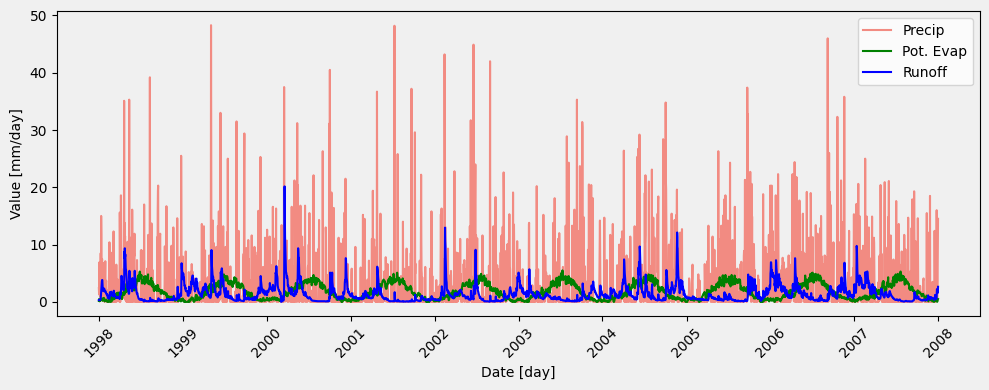

In [4]:
#Data visualization

plt.figure(figsize=(10, 4))
fig = plt.gcf()  # Get the current figure
fig.patch.set_facecolor('#f0f0f0')  # Set the figure background color

# Create an axis
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Set the axis background color

# Different colors for each variable
colors = {
    "pluie": "#f28b82",
    "etp": "green",
    "debit": "blue"
}

# Custom labels for the legend
legend_labels = {
    "pluie": "Precip",
    "etp": "Pot. Evap",
    "debit": "Runoff"
}

# Analysis period
start_date = '1998-01-01'
end_date = '2007-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create the DataFrame
dailyy = pd.DataFrame({
    'pluie': daily["P"].values[5114:8766],
    'etp': daily["E"].values[5114:8766],
    'debit': daily["Qmm"].values[5114:8766]
}, index=date_range)

# Variables to plot
ordered_vars = ["pluie", "etp", "debit"]

# X-axis ticks
start_year = 1998
end_year = 2008
years = list(range(start_year, end_year + 1))
ticks = pd.to_datetime([f'{year}-01-01' for year in years])

# Plot the three time series on the same figure
for var in ordered_vars:
    ax.plot(dailyy.index, dailyy[var], label=legend_labels[var], color=colors[var])

ax.set_xlabel('Date [day]')
ax.set_ylabel('Value [mm/day]')
ax.legend()

plt.xticks(ticks=ticks, labels=[tick.year for tick in ticks], rotation=45)

# Avoid overlapping
plt.tight_layout()

# Save the figure
plt.savefig("airGR_L0123001.jpeg", format='jpeg', dpi=700)

# Download the saved figure
#files.download("airGR_L0123001.jpeg")

plt.show()



In [5]:
#Calibration data
discharge = daily.iloc[5114:7671, -1].to_numpy()
plui = daily.iloc[5114:7671, 2].to_numpy() #Precipitation
etp = daily.iloc[5114:7671, 4].to_numpy() #PET

#Validation data
discharge1 = daily.iloc[7671:8766, -1].to_numpy()
plui1 = daily.iloc[7671:8766, 2].to_numpy()
etp1 = daily.iloc[7671:8766, 4].to_numpy()

In [6]:
discharge[0]

np.float64(0.3144)

In [7]:
discharge1[0]

np.float64(0.7608)

In [8]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


GR4J

We import the GR4J simulation results from R

In [9]:
GR4J = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Alone/GR4J_cal_airGR_L0123001.xlsx')
GR4J_val = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Alone/GR4J_vali_airGR_L0123001.xlsx')

simGR4J = GR4J.to_numpy()
simGR4J_val = GR4J_val.to_numpy()

In [10]:
simGR4J_val[-1]

array([2.85943503])

In [11]:
discharge1[-1]

np.float64(2.63496)

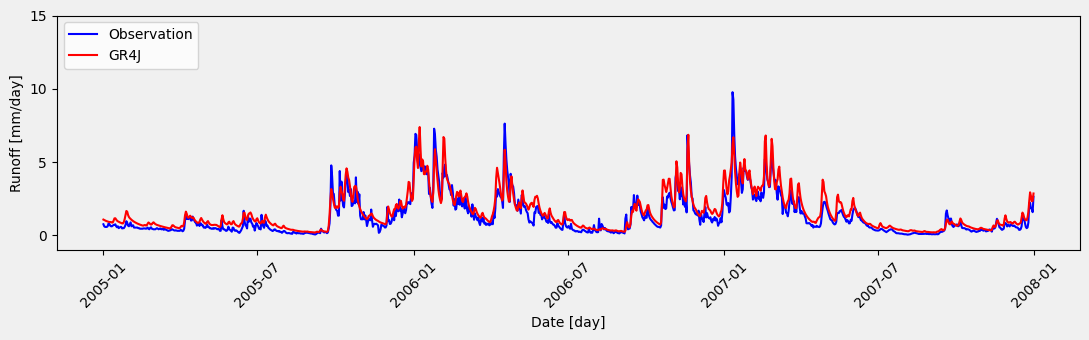

In [12]:
#Plot GR4J result

# Generate the dates
time1 = np.datetime64('2005-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharges
ax.plot(time, discharge1, 'b', label='Observation', linewidth=1.5)
ax.plot(time, simGR4J_val, 'red', label='GR4J', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-1, 15)
ax.set_yticks(np.arange(0, 16, 5))

# Add the legend
ax.legend(loc='upper left')

# Display the grid (optional)
# plt.grid(True)

# Avoid overlapping
plt.tight_layout()

# Save the figure
plt.savefig("airGR_L0123001_GR4J.jpeg", format='jpeg', dpi=700)

# Download the saved figure
#files.download("airGR_L0123001_GR4J.jpeg")

# Display the plot
plt.show()


In [13]:
#Calibration
simGR4J = simGR4J.flatten()
print('nashe=',nash_sutcliffe_efficiency(discharge[1:], simGR4J[1:]))
print('rmse=',calculate_rmse(discharge[1:], simGR4J[1:]))
print('r2=',calculate_r2(discharge[1:], simGR4J[1:]))

nashe= 0.806420165431453
rmse= 0.685258027114793
r2= 0.815878761966061


In [14]:
#Validation
simGR4J_val = simGR4J_val.flatten()
print('nashe=',nash_sutcliffe_efficiency(discharge1[1:], simGR4J_val[1:]))
print('rmse=',calculate_rmse(discharge1[1:], simGR4J_val[1:]))
print('r2=',calculate_r2(discharge1[1:], simGR4J_val[1:]))

nashe= 0.8339260466584755
rmse= 0.5437041372128236
r2= 0.8798924429812139


HyMoLAP

In [15]:
#State of the basin X(t)
def state_soil(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

In [16]:
#Compute the Effective precipitation
Pn = plui - etp
Pn[Pn < 0] = 0

#  model
nse = -100
Qsim = np.zeros(len(discharge))
Qsim[0] = discharge[0]

for pp in range(10000):
      mu = (1.9 - 1.2) * np.random.rand() + 1.2
      lambda_ = (90 - 20) * np.random.rand() + 20

      Xt = state_soil(mu, lambda_, Pn)

      for k in range(len(discharge)-1):

          Qsim[k+1] = Qsim[k] - (mu/lambda_) * Qsim[k]**(2*mu-1) +  (1/lambda_) * Xt[k] * Pn[k]


      #Nsh criteria
      nsee =  nash_sutcliffe_efficiency(discharge[1:], Qsim[1:])
      if nsee > nse:
          nse = nsee
          mu1 = mu
          lambda1 = lambda_
          Q_HyMoLAP = Qsim.copy()


print(nse)

<ipython-input-16-b492a42525ab>:18: RuntimeWarning: invalid value encountered in scalar power
  Qsim[k+1] = Qsim[k] - (mu/lambda_) * Qsim[k]**(2*mu-1) +  (1/lambda_) * Xt[k] * Pn[k]


0.471927784771239


In [17]:
print(mu1)
print(lambda1)

1.6573143506956798
56.28757520996287


In [18]:
# Calibration Perfromance evaluation
print('nashe=',nash_sutcliffe_efficiency(discharge[1:], Q_HyMoLAP[1:]))
print('rmse=',calculate_rmse(discharge[1:], Q_HyMoLAP[1:]))
print('r2=',calculate_r2(discharge[1:], Q_HyMoLAP[1:]))

nashe= 0.471927784771239
rmse= 1.1318027194822902
r2= 0.603346278392774


Validation

In [19]:
Pn1 = plui1 - etp1
Pn1[Pn1 < 0] = 0

In [20]:
#validation
size = len(discharge1)
Xt1 = state_soil(mu1, lambda1, Pn1)

Qval_HyM = np.zeros(size)
Qval_HyM[0] = discharge1[0]
for k in range(size-1):

    Qval_HyM[k+1] = Qval_HyM[k] - (mu1/lambda1) * Qval_HyM[k]**(2*mu1-1) +  (1/lambda1) * Xt1[k] * Pn1[k]

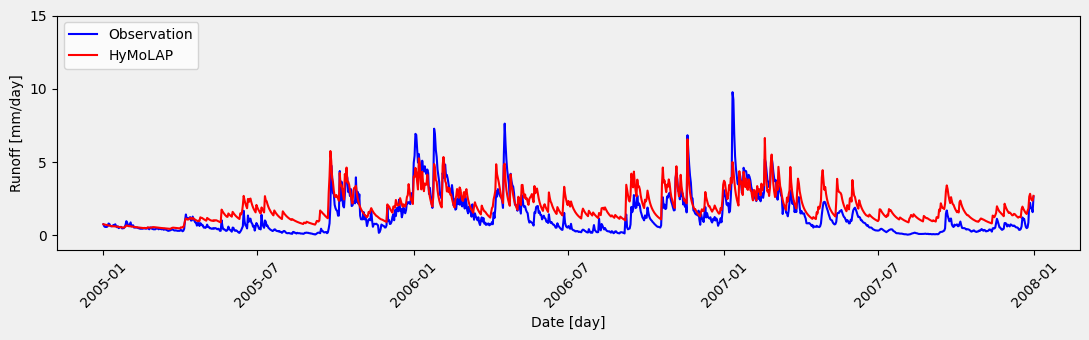

In [21]:
#Plot

# Generate the dates
time1 = np.datetime64('2005-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharges
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
# ax.plot(time, Qval_HyM, 'green', label='HyMoLAP', linewidth=1.5)
ax.plot(time, Qval_HyM, 'red', label='HyMoLAP', linewidth=1.5)
# ax.plot(time, mean_trajectory1, 'red', label='GR4J-HyMoLAP', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-1, 15)
ax.set_yticks(np.arange(0, 16, 5))

# Add the legend
ax.legend(loc='upper left')

# Display the grid (optional)
# plt.grid(True)

# Avoid overlapping
plt.tight_layout()

# Save the figure
plt.savefig("airGR_L0123001_HyMoLAP.jpeg", format='jpeg', dpi=700)

# Download the saved figure
#files.download("airGR_L0123001_HyMoLAP.jpeg")

# Display the plot
plt.show()


In [22]:
# Validation performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], Qval_HyM[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[1:], Qval_HyM[1:])
print('rmse=', rmse)

r2 = calculate_r2(discharge1[1:], Qval_HyM[1:])
print('r2=', r2)

Nash-Sutcliffe Efficiency (NSE): 0.46349266147785817
rmse= 0.9772365662843472
r2= 0.6839620857039201


GR4J-HyMoLAP

In [23]:
#Percolation

def Percolation(Pn, En, X1):
   n = len(Pn)
   S = np.zeros(n)
   S[0] =  Pn[0]

   Perc = np.zeros(n)
   ratio = (4.0 / 9.0) * (S[0] / X1)
   Perc[0] = S[0] * (1 - (1 + ratio**4) ** (-0.25))

   Pr = np.zeros(n)
   Pr[0] = Perc[0] + Pn[0]

   for i in range(1, n):
        temp = (S[i-1] / X1) ** 2
        frac = Pn[i] / X1
        Ps = X1 * (1 - temp) * np.tanh(frac) / (1 + (S[i-1] / X1) * np.tanh(frac))

        frac = En[i] / X1
        Es = S[i-1] * (2 - S[i-1] / X1) * np.tanh(frac) / (1 + (1 - S[i-1] / X1) * np.tanh(frac))

        S[i] = S[i-1] + Ps - Es

        ratio = (4.0 / 9.0) * (S[i] / X1)
        Perc[i] = S[i] * (1 - (1 + ratio**4) ** (-0.25))

        Pr[i] = Perc[i] + Pn[i] - Ps

   return Perc

In [24]:
#  model calibration : Here we chose the below ranges and then the optimal values found were:  mu = 0.9756486900089809, lambda_ = 6.261137845168766, X1 = 99.62821160899779,
# following the same calibration process with the HyMoLAP above.

En = etp - plui
En[En < 0] = 0

nse = -100
Qsim = np.zeros(len(discharge))
Qsim[0] = discharge[0]
Q1 = np.zeros(len(discharge))

for pp in range(1):
      mu = 0.9756486900089809 #(1.4 - 0.5) * np.random.rand() + 0.5
      lambda_ = 6.261137845168766 #(10 - 1) * np.random.rand() + 1
      X1 = 99.62821160899779 #(100 - 70) * np.random.rand() + 70

      Perc = Percolation(Pn, En, X1)

      for k in range(0, len(discharge)-1):

          Qsim[k+1] = Qsim[k] - (mu/lambda_) * Qsim[k]**(2*mu-1) +  (1/lambda_) * Perc[k] * Pn[k]

      #Nsh criteria
      nsee =  nash_sutcliffe_efficiency(discharge[1:], Qsim[1:])
      if nsee > nse:
          nse = nsee
          mu1 = mu
          lambda1 = lambda_
          X11 = X1
          GR4J_HyM = Qsim.copy()


print(nse)

0.6708540197644917


In [25]:
print(mu1)
print(lambda1)
print(X11)

0.9756486900089809
6.261137845168766
99.62821160899779


In [26]:
#Calibration performance
print('nashe=',nash_sutcliffe_efficiency(discharge[1:],  GR4J_HyM[1:]))
print('rmse=',calculate_rmse(discharge[1:],  GR4J_HyM[1:]))
print('r2=',calculate_r2(discharge[1:],  GR4J_HyM[1:]))

nashe= 0.6708540197644917
rmse= 0.8935489568574768
r2= 0.7273633888404886


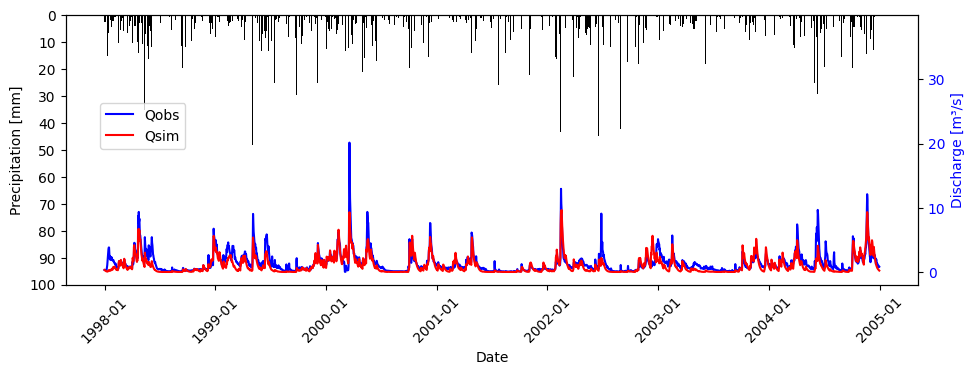

In [27]:
# Create a date range from '01-01-1998' to '12-31-2004'
time1 = np.datetime64('1998-01-01')
time2 = np.datetime64('2004-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(11., 3.5))

# Plot a histogram for precipitation on ax1
ax1.bar(time, plui, color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
ax1.set_xlabel('Date')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 10))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge, 'b', label='Qobs')

# Plot min, max, and mean values as confidence region
# ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='95% CrI')

# Plot the mean trajectories
ax2.plot(time, GR4J_HyM, 'red', label='Qsim')

# Y-axis settings for daily discharges
ax2.set_ylabel('Discharge [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-2, 40)
ax2.set_yticks(np.arange(0, 40, 10))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.65))

# Show grid
# plt.grid(True)

# Show the plot
plt.show()


Validation

In [28]:
Pn1 = plui1 - etp1
Pn1[Pn1 < 0] = 0

En1 = etp1 - plui1
En1[En1 < 0] = 0

In [29]:
# Simulation
size = len(discharge1)
Perc1 = Percolation(Pn1, En1, X11)
Xt1 = state_soil(mu1, lambda1, Pn1)

#EQUATION
Qval = np.zeros(size)
Qval[0] = discharge1[0]

for k in range(0, size-1):

    Qval[k+1] = Qval[k] - (mu1/lambda1) * Qval[k]**(2*mu1-1) +  (1/lambda1) * Perc1[k] * Pn1[k]


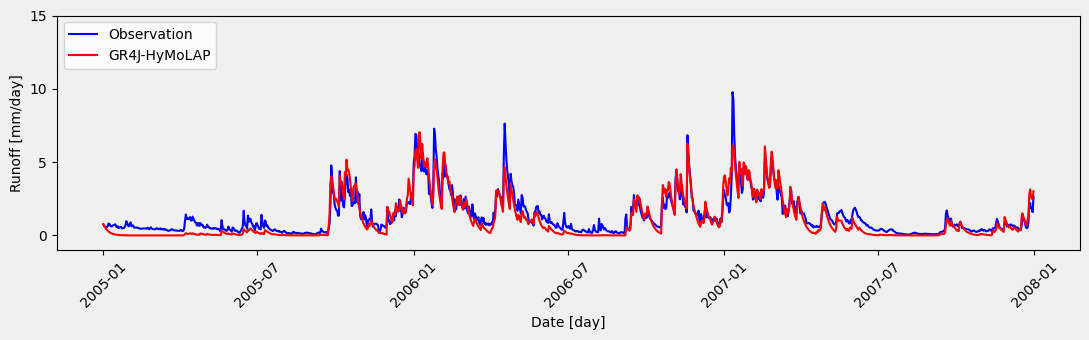

In [30]:
# Generate dates
time1 = np.datetime64('2005-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharges
ax.plot(time, discharge1, 'b', label='Observation', linewidth=1.5)
#ax.plot(time, Qval_HyM, 'green', label='HyMoLAP', linewidth=1.5)
ax.plot(time, Qval, 'red', label='GR4J-HyMoLAP', linewidth=1.5)
#ax.plot(time, mean_trajectory1, 'red', label='GR4J-HyMoLAP', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-1, 15)
ax.set_yticks(np.arange(0, 16, 5))

# Add legend
ax.legend(loc='upper left')

# Show grid
#plt.grid(True)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("hyM_save_val2.jpeg", format='jpeg', dpi=500)

# Save figure again with different name and dpi
plt.savefig("airGR_L0123001_GR4J-HyMoLAP.jpeg", format='jpeg', dpi=700)

#files.download("airGR_L0123001_GR4J-HyMoLAP.jpeg")

# Display figure
plt.show()


In [31]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1, Qval)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1, Qval)
print('rmse=', rmse)

r2 = calculate_r2(discharge1, Qval)
print('r2=', r2)

Nash-Sutcliffe Efficiency (NSE): 0.8324726667854867
rmse= 0.5458726450387722
r2= 0.8806127591849476


Hybrid HyMoLAP_GR4J_SVM

In [34]:
# Create the training DataFrame with Pe and plui
dataH = pd.DataFrame({
    'Qsim': GR4J_HyM,
    'prec': plui,
    'pet': etp,
    'perc': Perc,
    'target': discharge
})

# Create the test DataFrame with Pe1 and plui1
dataHH = pd.DataFrame({
    'Qsim': Qval,
    'prec': plui1,
    'pet': etp1,
    'perc': Perc1,
    'target': discharge1
})

# Split features and target for the training DataFrame
X_train = dataH[['Qsim', 'prec', 'pet', 'perc']]
y_train = dataH['target']

# Split features and target for the test DataFrame
X_test = dataHH[['Qsim', 'prec', 'pet', 'perc']]
y_test = dataHH['target']


In [35]:
# Setup the pipeline with StandardScaler and SVR
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('svr', SVR(kernel= 'rbf'))
])

# Parameter grid for hyperparameter tuning
param_grid = {
    'svr__C': [0.01, 0.1, 1, 10, 100, 1000],
    'svr__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'svr__epsilon': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
}

# Repeated K-Fold cross-validation for more robust evaluation
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearch
best_svr = grid_search.best_estimator_

# Predictions on test data
y_pred_test = best_svr.predict(X_test)

# Predictions on training data
y_pred_train = best_svr.predict(X_train)

# Calculate NSE for train and test (assuming you have a function nash_sutcliffe_efficiency)
nse_train = nash_sutcliffe_efficiency(y_train, y_pred_train)
nse_test  = nash_sutcliffe_efficiency(y_test, y_pred_test)

print(f"NSE on Training Data: {nse_train}")
print(f"NSE on Test Data: {nse_test}")


NSE on Training Data: 0.8460860682570133
NSE on Test Data: 0.8798035681535409


In [36]:
len(y_test)

1095

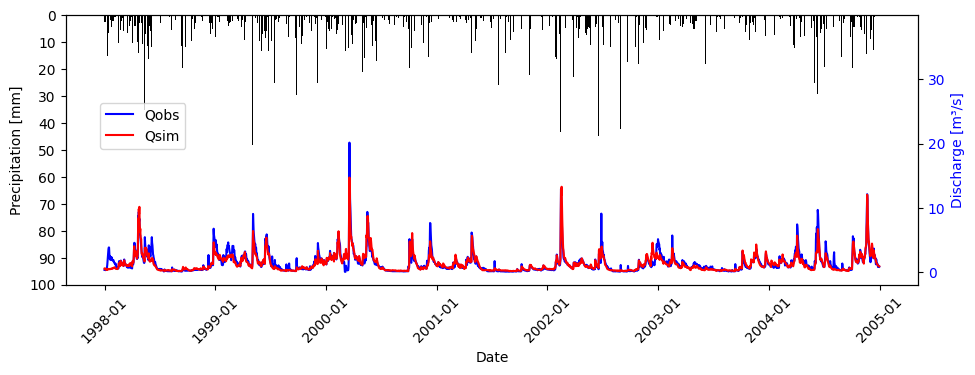

In [37]:
#Calibration plot

# Create a date range from '1998-01-01' to '2004-12-31'
time1 = np.datetime64('1998-01-01')
time2 = np.datetime64('2004-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(11., 3.5))

# Plot a histogram for plui on ax1
ax1.bar(time, plui, color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date')

# Y-axis settings for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 100)
ax1.set_yticks(np.arange(0, 101, 10))

# Invert y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharge
ax2 = ax1.twinx()
ax2.plot(time, discharge, 'b', label='Qobs')

# Plot min, max, and mean as confidence region
#ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='95% CrI')

# Plot the mean of trajectories
ax2.plot(time, y_pred_train, 'red', label='Qsim')

# Y-axis settings for daily discharge
ax2.set_ylabel('Discharge [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-2, 40)
ax2.set_yticks(np.arange(0, 40, 10))

# Add a legend inside the figure
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.65))

# Display the grid
#plt.grid(True)

# Add a title with LaTeX math symbols
#plt.title(r'$(\alpha = 1.3, \beta = -0.8, \gamma=1, \rho=0)$')

# Show the plot
plt.show()


In [38]:
#Training performance
nse_value = nash_sutcliffe_efficiency(discharge[1:], y_pred_train[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge[1:], y_pred_train[1:]))
print('r2=',calculate_r2(discharge[1:], y_pred_train[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.8460652425992794
rmse= 0.6110720504474435
r2= 0.8481329527855951


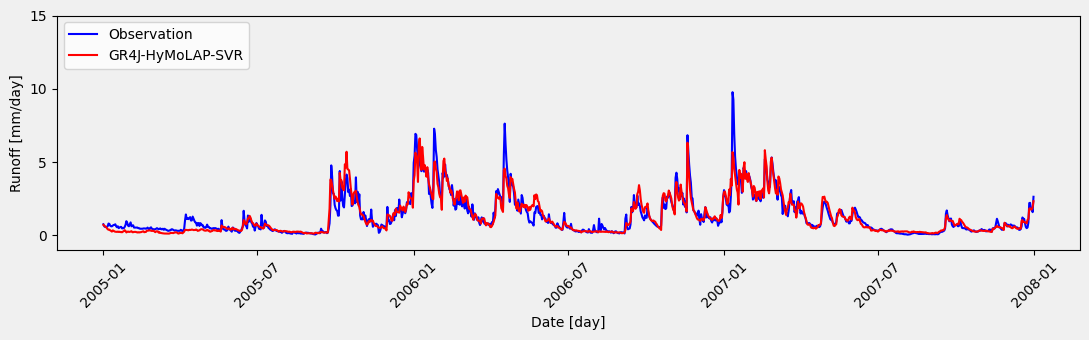

In [39]:
#Validation plot

# Generate the dates
time1 = np.datetime64('2005-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Set background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharge
ax.plot(time, discharge1, 'b', label='Observation', linewidth=1.5)
#ax.plot(time, Qval_HyM, 'green', label='HyMoLAP', linewidth=1.5)
ax.plot(time, y_pred_test, 'red', label='GR4J-HyMoLAP-SVR', linewidth=1.5)
#ax.plot(time, mean_trajectory1, 'red', label='GR4J-HyMoLAP', linewidth=1.5)

# X-axis settings (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis settings
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-1, 15)
ax.set_yticks(np.arange(0, 16, 5))

# Add the legend
ax.legend(loc='upper left')

# Show grid
#plt.grid(True)

# Avoid label overlap
plt.tight_layout()

# Save figure
plt.savefig("hyM_save_val2.jpeg", format='jpeg', dpi=500)

# Save figure with a different name and resolution
plt.savefig("airGR_L0123001_GR4J-HyMoLAP-SVR.jpeg", format='jpeg', dpi=700)

# Download the file
#files.download("airGR_L0123001_GR4J-HyMoLAP-SVR.jpeg")

# Display the plot
plt.show()


In [40]:
#Validation performance
nse_value = nash_sutcliffe_efficiency(discharge1[1:], y_pred_test[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], y_pred_test[1:]))
print('r2=',calculate_r2(discharge1[1:], y_pred_test[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.8797851367758898
rmse= 0.4625843747334304
r2= 0.8805144675218983


In [41]:
# Create a DataFrame to save the mean trajectory to an Excel file
df_mean_trajectory = pd.DataFrame({'test': y_pred_test})

# Save to an Excel file
df_mean_trajectory.to_excel('hybrid_SVM_france_validation.xlsx', index=False)

# Download the file in Google Colab
#files.download('hybrid_SVM_france_validation.xlsx')